In [1]:
'''
 * @Author: 11921006 Peixin Zhang 
 * @Date: 2019-05-27
'''

'\n * @Author: 11921006 Peixin Zhang \n * @Date: 2019-05-27\n'

In [2]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import pylab as pl

In [3]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

In [4]:
def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

In [5]:
def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [6]:
class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)
        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
      
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
   
        a = np.ravel(solution['x'])
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))
        
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)
     
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
            
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b
        
    def predict(self, X):
        return np.sign(self.project(X))

In [7]:
def gen_lin_separable_data():
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.6, 0.8], [0.8, 0.6]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

In [8]:
def split_data(X1, y1, X2, y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_train, y_train, X_test, y_test

In [9]:
def plot_margin(X1_train, X2_train, clf, kernel):
        def f(x, w, b, c=0):
            return (-w[0] * x - b + c) / w[1]
        
        pl.title('%s' % kernel)
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")
 
      
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")
 
        
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")
 
       
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")
 
        pl.axis("tight")
        pl.savefig('%s.png' % kernel)
        pl.show()

In [10]:
def plot_contour(X1_train, X2_train, clf, kernel):
    pl.title('%s' % kernel)
    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = clf.project(X).reshape(X1.shape)
    pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    pl.axis("tight")
    pl.savefig('%s.png' % kernel)
    pl.show()

In [11]:
def svm(X1, y1, X2, y2, kernel):
    clf = SVM(kernel=kernel)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))
    
    if kernel == linear_kernel:
        plot_margin(X_train[y_train==1], X_train[y_train==-1], clf, 'linear_kernel')
    else:
        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf, kernel.__name__)

In [12]:
X1, y1, X2, y2 = gen_lin_separable_data()
X_train, y_train, X_test, y_test = split_data(X1, y1, X2, y2)

/Users/pxzhang/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """
/Users/pxzhang/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  import sys


     pcost       dcost       gap    pres   dres
 0: -1.5787e+01 -2.8852e+01  5e+02  2e+01  2e+00
 1: -1.8383e+01 -1.0023e+01  1e+02  5e+00  4e-01
 2: -5.1365e+01 -2.2891e+01  1e+02  4e+00  4e-01
 3: -1.5693e+01 -5.7912e+00  3e+01  8e-01  7e-02
 4: -3.6514e+00 -4.4815e+00  2e+00  2e-02  2e-03
 5: -3.8238e+00 -4.2288e+00  6e-01  6e-03  5e-04
 6: -4.0792e+00 -4.1224e+00  4e-02  1e-05  1e-06
 7: -4.1201e+00 -4.1205e+00  4e-04  1e-07  1e-08
 8: -4.1205e+00 -4.1205e+00  4e-06  1e-09  1e-10
 9: -4.1205e+00 -4.1205e+00  4e-08  1e-11  1e-12
Optimal solution found.
3 support vectors out of 180 points
20 out of 20 predictions correct


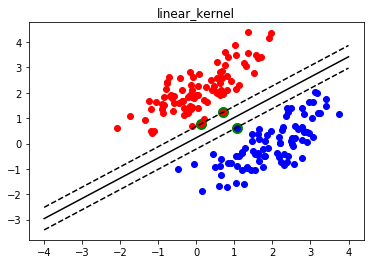

In [13]:
svm(X1, y1, X2, y2, linear_kernel)

     pcost       dcost       gap    pres   dres
 0: -4.4903e+00 -8.0556e+00  4e+02  2e+01  2e+00
 1: -4.4216e+00 -2.6261e+00  6e+01  3e+00  3e-01
 2: -1.8457e+00 -1.4818e+00  3e+00  2e-01  2e-02
 3: -1.4122e+00 -1.1212e+00  2e+00  7e-02  7e-03
 4: -1.1732e+00 -8.3014e-01  8e-01  3e-02  3e-03
 5: -9.1580e-01 -5.9151e-01  7e-01  2e-02  2e-03
 6: -7.0132e-01 -5.1353e-01  5e-01  1e-02  1e-03
 7: -5.6065e-01 -4.6998e-01  4e-01  7e-03  7e-04
 8: -4.5720e-01 -4.5926e-01  1e-01  2e-03  2e-04
 9: -4.3653e-01 -4.5450e-01  4e-02  3e-04  3e-05
10: -4.5023e-01 -4.5297e-01  3e-03  7e-06  8e-07
11: -4.5270e-01 -4.5278e-01  9e-05  2e-07  2e-08
12: -4.5277e-01 -4.5277e-01  1e-06  2e-09  2e-10
13: -4.5277e-01 -4.5277e-01  1e-08  2e-11  2e-12
Optimal solution found.
6 support vectors out of 180 points
20 out of 20 predictions correct


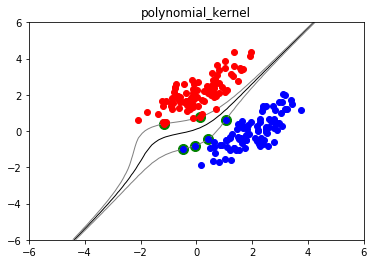

In [14]:
svm(X1, y1, X2, y2, polynomial_kernel)

     pcost       dcost       gap    pres   dres
 0: -1.9664e+01 -5.0594e+01  4e+02  2e+01  2e+00
 1: -1.9276e+01 -5.3534e+01  1e+02  6e+00  5e-01
 2: -5.8416e+01 -8.4106e+01  1e+02  5e+00  5e-01
 3: -9.8922e+01 -1.2194e+02  1e+02  3e+00  3e-01
 4: -1.0529e+02 -1.1196e+02  4e+01  9e-01  9e-02
 5: -1.0196e+02 -1.0379e+02  2e+00  5e-14  5e-14
 6: -1.0361e+02 -1.0363e+02  2e-02  8e-14  5e-14
 7: -1.0362e+02 -1.0362e+02  2e-04  3e-14  5e-14
 8: -1.0362e+02 -1.0362e+02  2e-06  4e-14  4e-14
Optimal solution found.
3 support vectors out of 180 points
20 out of 20 predictions correct


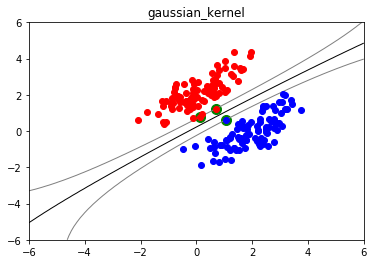

In [15]:
svm(X1, y1, X2, y2, gaussian_kernel)